In [4]:
import os
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.colors import LinearSegmentedColormap
import seaborn as sns
import matplotlib.colors as mcolors
from datetime import datetime, timedelta
from matplotlib.patches import Patch
import json
from collections import defaultdict

#### Code to get gridded erosion data from cloud server and cluster into parallel data cubes of erosion metrics and cluster IDs

In [2]:
# loading data from reefbreak by location
def find_csv_files(location, erosion=True, res_cm=10, cleaned=False):
    """
    Returns a sorted list of paths to all *_grid_{res_cm}cm.csv
    in /…/results/<location>/{erosion,deposition}/<date>/.
    """
    base = "/Volumes/group/LiDAR/LidarProcessing/LidarProcessingCliffs/results"
    mode = "erosion" if erosion else "deposition"
    root = os.path.join(base, location, mode)
    
    date_re = re.compile(r"(\d{8})")
    out = []
    for date in sorted(os.listdir(root)):
        ddir = os.path.join(root, date)
        if not os.path.isdir(ddir):
            continue
        for fn in os.listdir(ddir):
            if not cleaned:
                if fn.endswith(f"_grid_{res_cm}cm_filled.csv") and (
                (erosion and "_ero_" in fn) or (not erosion and "_dep_" in fn)
                ):
                    m = date_re.search(fn)
                    if m:
                        out.append((m.group(1), os.path.join(ddir, fn)))
            else:
                if fn.endswith(f"_grid_{res_cm}cm_filled.csv") and (
                (erosion and "_ero_" in fn) or (not erosion and "_dep_" in fn)
                ):
                    m = date_re.search(fn)
                    if m:
                        out.append((m.group(1), os.path.join(ddir, fn)))
    # sort by date prefix
    out.sort(key=lambda x: x[0])
    return [path for (_, path) in out]


def find_cluster_csv_files(location, erosion=True, res_cm=10, cleaned=False):
    """
    Returns a sorted list of paths to all *_clusters_{res_cm}cm.csv files
    in /…/results/<location>/{erosion,deposition}/<date>/.
    """
    base = "/Volumes/group/LiDAR/LidarProcessing/LidarProcessingCliffs/results"
    mode = "erosion" if erosion else "deposition"
    root = os.path.join(base, location, mode)
    
    date_re = re.compile(r"(\d{8})")
    out = []
    for date in sorted(os.listdir(root)):
        ddir = os.path.join(root, date)
        if not os.path.isdir(ddir):
            continue
        for fn in os.listdir(ddir):
            if not cleaned:
                # Look for cluster files instead of grid files
                if fn.endswith(f"_clusters_{res_cm}cm_filled.csv") and (
                (erosion and "_ero_" in fn) or (not erosion and "_dep_" in fn)
                ):
                    m = date_re.search(fn)
                    if m:
                        out.append((m.group(1), os.path.join(ddir, fn)))
            else:
                if fn.endswith(f"_clusters_{res_cm}cm_filled.csv") and (
                (erosion and "_ero_" in fn) or (not erosion and "_dep_" in fn)
                ):
                    m = date_re.search(fn)
                    if m:
                        out.append((m.group(1), os.path.join(ddir, fn)))
    # sort by date prefix
    out.sort(key=lambda x: x[0])
    return [path for (_, path) in out]

# Load both grid and cluster data for a location
def load_grid_and_cluster_cubes(location, erosion=True, res_cm=10, cleaned=False):
    """
    Load both erosion/deposition grid data and cluster data for a location.
    Returns grid_cube, grid_files, cluster_cube, cluster_files
    """
    # Load grid data
    grid_files = find_csv_files(location, erosion=erosion, res_cm=res_cm, cleaned=cleaned)
    grid_cube, valid_grid_files = load_csv_to_numpy(grid_files)
    
    # Load cluster data
    cluster_files = find_cluster_csv_files(location, erosion=erosion, res_cm=res_cm, cleaned=cleaned)
    cluster_cube, valid_cluster_files = load_csv_to_numpy(cluster_files)
    
    print(f"Grid cube shape: {grid_cube.shape}")
    print(f"Cluster cube shape: {cluster_cube.shape}")
    
    return grid_cube, valid_grid_files, cluster_cube, valid_cluster_files

# turn csv grids into numpy arrays
def load_csv_to_numpy(file_list):
    """
    Loads CSV grids into a 3D NumPy array, with error checking for shape mismatches.
    Mismatched grids are omitted from the final cube.
    """
    grids = []
    shapes = []
    valid_files = []
    
    for fp in file_list:
        df = pd.read_csv(fp, index_col=0)
        grids.append(df.values)
        shapes.append((fp, df.shape))
        valid_files.append(fp)

    if not grids:
        raise ValueError("No valid CSV files found.")
    
    # Get reference shape from first file
    ref_shape = shapes[0][1]
    
    # Filter out mismatched grids
    valid_grids = []
    valid_files_final = []
    mismatches = []
    
    for i, (fp, shape) in enumerate(shapes):
        if shape == ref_shape:
            valid_grids.append(grids[i])
            valid_files_final.append(fp)
        else:
            mismatches.append((fp, shape))
    
    if mismatches:
        print(f"\n⚠️ Omitting {len(mismatches)} files with mismatched grid shapes:")
        for fp, shape in mismatches:
            print(f"  {os.path.basename(fp)} — shape = {shape}, expected = {ref_shape}")
        print(f"\n✅ Using {len(valid_grids)} files with consistent shape {ref_shape}")
    
    if not valid_grids:
        raise ValueError("No files have consistent grid shapes.")
    
    return np.stack(valid_grids, axis=0), valid_files_final

In [3]:
# List of all locations to process
locations = ["Torrey", "Solana", "Encinitas", "SanElijo", "Blacks"] # Delmar", 

def process_location(location):
    """Process a single location: load data, create cubes, and save files"""
    
    print(f"\n{'='*50}")
    print(f"Processing {location}...")
    print(f"{'='*50}")
    
    try:
        # Create data_cubes directory if it doesn't exist
        output_dir = f"/Volumes/group/LiDAR/LidarProcessing/LidarProcessingCliffs/results/{location}/data_cubes"
        os.makedirs(output_dir, exist_ok=True)
        
        # Load both grid and cluster data for erosion
        grid_cube, grid_files, cluster_cube, cluster_files = load_grid_and_cluster_cubes(
            location, erosion=True, res_cm=10, cleaned=False
        )
        
        # Save both cubes
        grid_path = os.path.join(output_dir, "cube_ero_10cm_filled.npz")
        cluster_path = os.path.join(output_dir, "cube_clusters_ero_10cm_filled.npz")
        
        np.savez_compressed(grid_path, data=grid_cube)
        np.savez_compressed(cluster_path, data=cluster_cube)
        
        print(f"✅ Saved grid cube: {grid_path}")
        print(f"✅ Saved cluster cube: {cluster_path}")
        
        # Save file lists
        grid_files_path = os.path.join(output_dir, "files_ero.json")
        cluster_files_path = os.path.join(output_dir, "files_clusters_ero.json")
        
        with open(grid_files_path, "w") as f:
            json.dump(grid_files, f, indent=2)
        
        with open(cluster_files_path, "w") as f:
            json.dump(cluster_files, f, indent=2)
        
        print(f"✅ Saved grid file list: {grid_files_path}")
        print(f"✅ Saved cluster file list: {cluster_files_path}")
        
        # Print summary
        print(f"\n📊 {location} Summary:")
        print(f"   Grid cube shape: {grid_cube.shape}")
        print(f"   Cluster cube shape: {cluster_cube.shape}")
        print(f"   Number of time steps: {len(grid_files)}")
        print(f"   Grid file size: {grid_cube.nbytes / (1024**3):.2f} GB")
        print(f"   Cluster file size: {cluster_cube.nbytes / (1024**3):.2f} GB")
        
        return True
        
    except Exception as e:
        print(f"❌ Error processing {location}: {str(e)}")
        return False

# Process all locations
successful_locations = []
failed_locations = []

print("Starting batch processing of all locations...")
print(f"Locations to process: {', '.join(locations)}")

for location in locations:
    success = process_location(location)
    
    if success:
        successful_locations.append(location)
    else:
        failed_locations.append(location)

# Final summary
print(f"\n{'='*60}")
print("BATCH PROCESSING COMPLETE")
print(f"{'='*60}")

print(f"\n✅ Successfully processed ({len(successful_locations)}/{len(locations)}):")
for loc in successful_locations:
    print(f"   - {loc}")

if failed_locations:
    print(f"\n❌ Failed to process ({len(failed_locations)}/{len(locations)}):")
    for loc in failed_locations:
        print(f"   - {loc}")
else:
    print(f"\n🎉 All {len(locations)} locations processed successfully!")

print(f"\nData cubes saved to:")
for loc in successful_locations:
    print(f"   {loc}: /Volumes/group/LiDAR/LidarProcessing/LidarProcessingCliffs/results/{loc}/data_cubes/")

Starting batch processing of all locations...
Locations to process: Torrey, Solana, Encinitas, SanElijo, Blacks

Processing Torrey...

⚠️ Omitting 3 files with mismatched grid shapes:
  20220518_to_20220518_ero_grid_10cm_filled.csv — shape = (12888, 1), expected = (12888, 750)
  20230120_to_20230120_ero_grid_10cm_filled.csv — shape = (12888, 1), expected = (12888, 750)
  20241126_to_20241126_ero_grid_10cm_filled.csv — shape = (12888, 1), expected = (12888, 750)

✅ Using 301 files with consistent shape (12888, 750)

⚠️ Omitting 3 files with mismatched grid shapes:
  20220518_to_20220518_ero_clusters_10cm_filled.csv — shape = (12888, 1), expected = (12888, 750)
  20230120_to_20230120_ero_clusters_10cm_filled.csv — shape = (12888, 1), expected = (12888, 750)
  20241126_to_20241126_ero_clusters_10cm_filled.csv — shape = (12888, 1), expected = (12888, 750)

✅ Using 301 files with consistent shape (12888, 750)
Grid cube shape: (301, 12888, 750)
Cluster cube shape: (301, 12888, 750)
✅ Saved g

##### Code to split erosion cubes into small small and sig erosion events (10 cubic meter threshold)

In [7]:
def calculate_timestep_cluster_volumes(erosion_slice, cluster_slice, resolution_cm=10):
    """
    Calculate volume for each cluster ID in a single timestep
    
    Args:
        erosion_slice: (H, W) erosion values in cm for one timestep
        cluster_slice: (H, W) cluster IDs for one timestep
        resolution_cm: spatial resolution in cm
    
    Returns:
        dict: {cluster_id: volume_m3} for this timestep only
    """
    cluster_volumes = {}
    
    # Get unique cluster IDs (excluding 0/NaN)
    unique_clusters = np.unique(cluster_slice)
    unique_clusters = unique_clusters[unique_clusters > 0]  # Remove 0 and negative
    unique_clusters = unique_clusters[~np.isnan(unique_clusters)]  # Remove NaN
    
    for cluster_id in unique_clusters:
        # Get mask for this cluster
        cluster_mask = cluster_slice == cluster_id
        
        # Get erosion values for this cluster (in cm)
        cluster_erosion_cm = erosion_slice[cluster_mask]
        
        # Remove NaN values
        cluster_erosion_cm = cluster_erosion_cm[~np.isnan(cluster_erosion_cm)]
        
        if len(cluster_erosion_cm) > 0:
            # Calculate volume: sum(erosion_cm) * 0.01 (for 10cm pixels)
            volume_m3 = np.sum(cluster_erosion_cm) * 0.01
            cluster_volumes[cluster_id] = volume_m3
    
    return cluster_volumes


def separate_erosion_by_volume(erosion_cube, cluster_cube, volume_threshold_m3=10.0, 
                                resolution_cm=10):
    """
    Separate erosion cube into significant and small events based on cluster volume
    Processing each timestep independently since cluster IDs reset each timestep
    
    Args:
        erosion_cube: (T, H, W) erosion values
        cluster_cube: (T, H, W) cluster IDs
        volume_threshold_m3: threshold in cubic meters
        resolution_cm: spatial resolution
    
    Returns:
        erosion_sig: cube with only significant events
        erosion_small: cube with only small events
        cluster_sig: cube with cluster IDs for significant events only
        cluster_small: cube with cluster IDs for small events only
        all_cluster_volumes: list of dicts with volumes for each timestep
        stats: dictionary with statistics
    """
    
    # Initialize output cubes
    erosion_sig = np.full_like(erosion_cube, np.nan, dtype=float)
    erosion_small = np.full_like(erosion_cube, np.nan, dtype=float)
    cluster_sig = np.zeros_like(cluster_cube, dtype=cluster_cube.dtype)
    cluster_small = np.zeros_like(cluster_cube, dtype=cluster_cube.dtype)
    
    # Store volumes for each timestep
    all_cluster_volumes = []
    
    # Statistics tracking
    total_clusters = 0
    sig_clusters_count = 0
    small_clusters_count = 0
    sig_volume_total = 0.0
    small_volume_total = 0.0
    
    print(f"Processing {erosion_cube.shape[0]} timesteps...")
    
    # Process each timestep independently
    for t in range(erosion_cube.shape[0]):
        # Calculate volumes for this timestep
        timestep_volumes = calculate_timestep_cluster_volumes(
            erosion_cube[t], cluster_cube[t], resolution_cm
        )
        
        # Store volumes for this timestep
        all_cluster_volumes.append(timestep_volumes)
        
        # Classify clusters for this timestep
        sig_clusters = set([cid for cid, vol in timestep_volumes.items() if vol > volume_threshold_m3])
        small_clusters = set([cid for cid, vol in timestep_volumes.items() if vol <= volume_threshold_m3])
        
        # Update statistics
        total_clusters += len(timestep_volumes)
        sig_clusters_count += len(sig_clusters)
        small_clusters_count += len(small_clusters)
        sig_volume_total += sum([vol for cid, vol in timestep_volumes.items() if cid in sig_clusters])
        small_volume_total += sum([vol for cid, vol in timestep_volumes.items() if cid in small_clusters])
        
        # Create masks for this timestep
        if sig_clusters:
            sig_mask = np.isin(cluster_cube[t], list(sig_clusters))
            erosion_sig[t][sig_mask] = erosion_cube[t][sig_mask]
            cluster_sig[t][sig_mask] = cluster_cube[t][sig_mask]
        
        if small_clusters:
            small_mask = np.isin(cluster_cube[t], list(small_clusters))
            erosion_small[t][small_mask] = erosion_cube[t][small_mask]
            cluster_small[t][small_mask] = cluster_cube[t][small_mask]
        
        if (t + 1) % 10 == 0 or t == erosion_cube.shape[0] - 1:
            print(f"  Processed timestep {t + 1}/{erosion_cube.shape[0]} - "
                  f"Sig: {len(sig_clusters)}, Small: {len(small_clusters)}")
    
    # Calculate final statistics
    stats = {
        'total_timesteps': erosion_cube.shape[0],
        'total_clusters': total_clusters,
        'significant_clusters': sig_clusters_count,
        'small_clusters': small_clusters_count,
        'threshold_m3': volume_threshold_m3,
        'significant_volume_m3': sig_volume_total,
        'small_volume_m3': small_volume_total,
        'significant_fraction': sig_clusters_count / total_clusters if total_clusters > 0 else 0,
        'volume_fraction_significant': sig_volume_total / (sig_volume_total + small_volume_total) if (sig_volume_total + small_volume_total) > 0 else 0,
        'avg_clusters_per_timestep': total_clusters / erosion_cube.shape[0] if erosion_cube.shape[0] > 0 else 0,
        'avg_sig_clusters_per_timestep': sig_clusters_count / erosion_cube.shape[0] if erosion_cube.shape[0] > 0 else 0
    }
    
    print(f"\nCluster classification summary:")
    print(f"  Total clusters across all timesteps: {total_clusters}")
    print(f"  Significant clusters (>{volume_threshold_m3} m³): {sig_clusters_count} ({stats['significant_fraction']*100:.1f}%)")
    print(f"  Small clusters (≤{volume_threshold_m3} m³): {small_clusters_count} ({(1-stats['significant_fraction'])*100:.1f}%)")
    print(f"  Average clusters per timestep: {stats['avg_clusters_per_timestep']:.1f}")
    
    return erosion_sig, erosion_small, cluster_sig, cluster_small, all_cluster_volumes, stats


def process_location_separation(location, volume_threshold_m3=10.0, resolution_cm=10):
    """
    Load existing data cubes, separate by volume, and save new files
    
    Args:
        location: location name (e.g., "Delmar")
        volume_threshold_m3: volume threshold in cubic meters
        resolution_cm: spatial resolution in cm
    """
    print(f"\n{'='*60}")
    print(f"Processing {location} - Volume Threshold: {volume_threshold_m3} m³")
    print(f"{'='*60}")
    
    try:
        # Define paths
        data_dir = f"/Volumes/group/LiDAR/LidarProcessing/LidarProcessingCliffs/results/{location}/data_cubes"
        
        erosion_path = os.path.join(data_dir, "cube_ero_10cm_filled.npz")
        cluster_path = os.path.join(data_dir, "cube_clusters_ero_10cm_filled.npz")
        
        # Check if files exist
        if not os.path.exists(erosion_path):
            print(f"❌ Erosion cube not found: {erosion_path}")
            return False
        
        if not os.path.exists(cluster_path):
            print(f"❌ Cluster cube not found: {cluster_path}")
            return False
        
        # Load data
        print(f"Loading data cubes...")
        erosion_cube = np.load(erosion_path)['data']
        cluster_cube = np.load(cluster_path)['data']
        
        print(f"  Erosion cube shape: {erosion_cube.shape}")
        print(f"  Cluster cube shape: {cluster_cube.shape}")
        print(f"  Erosion value range: {np.nanmin(erosion_cube):.2f} to {np.nanmax(erosion_cube):.2f} cm")
        print(f"  Cluster ID range: {np.nanmin(cluster_cube[cluster_cube > 0]):.0f} to {np.nanmax(cluster_cube):.0f}")
        
        # Separate by volume
        erosion_sig, erosion_small, cluster_sig, cluster_small, all_cluster_volumes, stats = separate_erosion_by_volume(
            erosion_cube, cluster_cube, volume_threshold_m3, resolution_cm
        )
        
        # Save separated cubes
        erosion_sig_path = os.path.join(data_dir, "cube_ero_10cm_sig.npz")
        erosion_small_path = os.path.join(data_dir, "cube_ero_10cm_small.npz")
        cluster_sig_path = os.path.join(data_dir, "cube_clusters_10cm_sig.npz")
        cluster_small_path = os.path.join(data_dir, "cube_clusters_10cm_small.npz")
        
        print(f"\nSaving separated cubes...")
        np.savez_compressed(erosion_sig_path, data=erosion_sig)
        np.savez_compressed(erosion_small_path, data=erosion_small)
        np.savez_compressed(cluster_sig_path, data=cluster_sig)
        np.savez_compressed(cluster_small_path, data=cluster_small)
        
        print(f"✅ Saved significant erosion: {erosion_sig_path}")
        print(f"✅ Saved small erosion: {erosion_small_path}")
        print(f"✅ Saved significant clusters: {cluster_sig_path}")
        print(f"✅ Saved small clusters: {cluster_small_path}")
        
        # Save cluster volumes and statistics
        volumes_path = os.path.join(data_dir, "cluster_volumes_by_timestep.json")
        stats_path = os.path.join(data_dir, "separation_stats.json")
        
        # Convert numpy types to native Python types for JSON serialization
        volumes_serializable = []
        for t, timestep_vols in enumerate(all_cluster_volumes):
            volumes_serializable.append({
                'timestep': t,
                'cluster_volumes': {int(k): float(v) for k, v in timestep_vols.items()}
            })
        
        with open(volumes_path, "w") as f:
            json.dump(volumes_serializable, f, indent=2)
        
        with open(stats_path, "w") as f:
            json.dump(stats, f, indent=2)
        
        print(f"✅ Saved cluster volumes: {volumes_path}")
        print(f"✅ Saved statistics: {stats_path}")
        
        # Print summary statistics
        print(f"\n📊 {location} Statistics:")
        print(f"   Total timesteps: {stats['total_timesteps']}")
        print(f"   Total clusters: {stats['total_clusters']}")
        print(f"   Significant clusters: {stats['significant_clusters']} ({stats['significant_fraction']*100:.1f}%)")
        print(f"   Small clusters: {stats['small_clusters']} ({(1-stats['significant_fraction'])*100:.1f}%)")
        print(f"   Average clusters per timestep: {stats['avg_clusters_per_timestep']:.1f}")
        print(f"   Average significant clusters per timestep: {stats['avg_sig_clusters_per_timestep']:.1f}")
        print(f"   Total significant volume: {stats['significant_volume_m3']:.2f} m³")
        print(f"   Total small volume: {stats['small_volume_m3']:.2f} m³")
        print(f"   Volume fraction (significant): {stats['volume_fraction_significant']*100:.1f}%")
        
        # Find and print some examples of large clusters
        large_examples = []
        for t, timestep_vols in enumerate(all_cluster_volumes):
            for cid, vol in timestep_vols.items():
                if vol > volume_threshold_m3:
                    large_examples.append((t, cid, vol))
        
        if large_examples:
            large_examples.sort(key=lambda x: x[2], reverse=True)  # Sort by volume
            print(f"\n   Top 10 largest individual clusters:")
            for i, (t, cid, vol) in enumerate(large_examples[:10]):
                print(f"      {i+1}. Timestep {t}, Cluster {int(cid)}: {vol:.2f} m³")
        else:
            print(f"\n   No individual clusters found above {volume_threshold_m3} m³ threshold")
        
        return True
        
    except Exception as e:
        print(f"❌ Error processing {location}: {str(e)}")
        import traceback
        traceback.print_exc()
        return False


def main():
    """Process all locations and separate erosion by cluster volume"""
    
    # Configuration
    locations = ["Delmar", "Torrey", "Solana", "Encinitas", "SanElijo"] #, "Blacks"]
    volume_threshold_m3 = 10.0  # 10 cubic meters
    resolution_cm = 10  # 10 cm spatial resolution
    
    print("="*60)
    print("EROSION SEPARATION BY CLUSTER VOLUME (PER TIMESTEP)")
    print("="*60)
    print(f"\nConfiguration:")
    print(f"  Volume threshold: {volume_threshold_m3} m³")
    print(f"  Spatial resolution: {resolution_cm} cm")
    print(f"  Locations to process: {len(locations)}")
    print(f"  Processing: Each timestep independently (cluster IDs reset each timestep)")
    
    # Process all locations
    successful = []
    failed = []
    
    for location in locations:
        success = process_location_separation(location, volume_threshold_m3, resolution_cm)
        
        if success:
            successful.append(location)
        else:
            failed.append(location)
    
    # Final summary
    print(f"\n{'='*60}")
    print("PROCESSING COMPLETE")
    print(f"{'='*60}")
    
    print(f"\n✅ Successfully processed ({len(successful)}/{len(locations)}):")
    for loc in successful:
        print(f"   - {loc}")
    
    if failed:
        print(f"\n❌ Failed to process ({len(failed)}/{len(locations)}):")
        for loc in failed:
            print(f"   - {loc}")
    else:
        print(f"\n🎉 All {len(locations)} locations processed successfully!")
    
    print(f"\nOutput files for each location:")
    print(f"   - cube_ero_10cm_sig.npz          (significant erosion events > {volume_threshold_m3} m³)")
    print(f"   - cube_ero_10cm_small.npz        (small erosion events ≤ {volume_threshold_m3} m³)")
    print(f"   - cube_clusters_10cm_sig.npz     (significant cluster IDs)")
    print(f"   - cube_clusters_10cm_small.npz   (small cluster IDs)")
    print(f"   - cluster_volumes_by_timestep.json (volumes for each cluster by timestep)")
    print(f"   - separation_stats.json          (summary statistics)")


if __name__ == "__main__":
    main()

EROSION SEPARATION BY CLUSTER VOLUME (PER TIMESTEP)

Configuration:
  Volume threshold: 10.0 m³
  Spatial resolution: 10 cm
  Locations to process: 5
  Processing: Each timestep independently (cluster IDs reset each timestep)

Processing Delmar - Volume Threshold: 10.0 m³
Loading data cubes...
  Erosion cube shape: (321, 22850, 300)
  Cluster cube shape: (321, 22850, 300)
  Erosion value range: 0.00 to 18.07 cm
  Cluster ID range: 1 to 1715
Processing 321 timesteps...
  Processed timestep 10/321 - Sig: 2, Small: 21
  Processed timestep 20/321 - Sig: 3, Small: 59
  Processed timestep 30/321 - Sig: 0, Small: 10
  Processed timestep 40/321 - Sig: 0, Small: 9
  Processed timestep 50/321 - Sig: 0, Small: 13
  Processed timestep 60/321 - Sig: 0, Small: 8
  Processed timestep 70/321 - Sig: 1, Small: 108
  Processed timestep 80/321 - Sig: 9, Small: 234
  Processed timestep 90/321 - Sig: 0, Small: 36
  Processed timestep 100/321 - Sig: 0, Small: 13
  Processed timestep 110/321 - Sig: 0, Small: 

##### Plot by height to find logical cutoff elevation for large "upper" cliff vs "lower" cliff events

SIGNIFICANT EROSION EVENTS BUBBLE PLOT - FROM SIG CUBES ONLY
Loading Delmar...
  Loading significant erosion and cluster cubes...
  Found 321 timesteps, sig cube shape: (321, 22850, 300)
  Found 336 significant events
Loading Torrey...
  Loading significant erosion and cluster cubes...
  Found 301 timesteps, sig cube shape: (301, 12888, 750)
  Found 588 significant events
Loading Solana...
  Loading significant erosion and cluster cubes...
  Found 117 timesteps, sig cube shape: (117, 28845, 500)
  Found 843 significant events
Loading Encinitas...
  Loading significant erosion and cluster cubes...
  Found 104 timesteps, sig cube shape: (104, 55824, 500)
  Found 704 significant events
Loading SanElijo...
  Loading significant erosion and cluster cubes...
  Found 115 timesteps, sig cube shape: (115, 23825, 399)
  Found 314 significant events

Total events across all locations: 2785

📊 Plot Summary:
   Total events plotted: 2785
   Date range: 2017-03-23 to 2025-03-24
   Volume range: 10.0

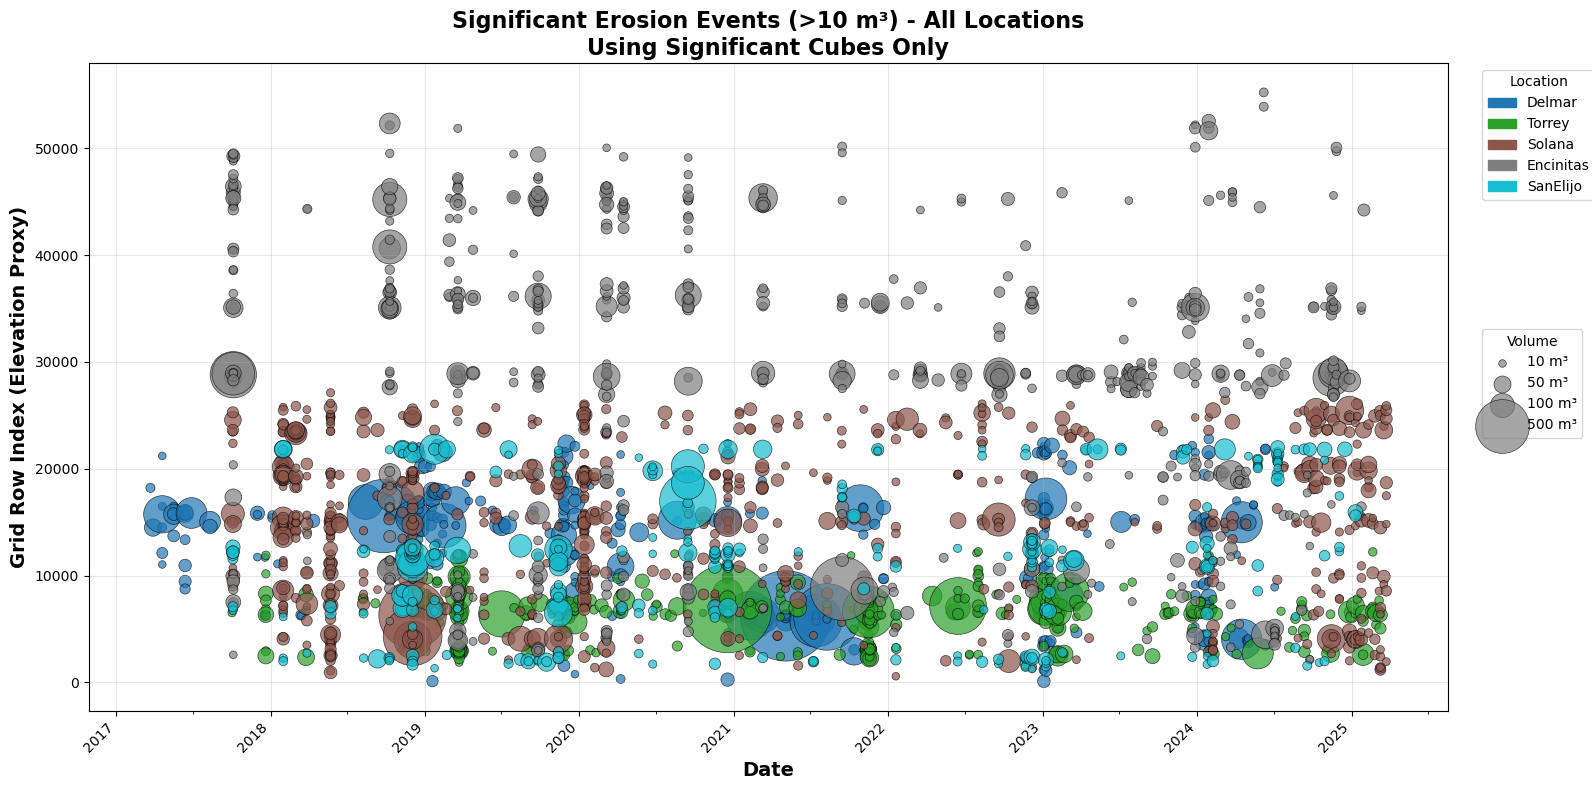

In [13]:
import matplotlib.pyplot as plt
import numpy as np
import json
import os
from datetime import datetime
import matplotlib.patches as mpatches

def get_cluster_elevation(cluster_slice, cluster_id):
    """
    Calculate the mean elevation (centroid) of a cluster
    
    Args:
        cluster_slice: (H, W) cluster IDs for one timestep  
        cluster_id: the specific cluster ID to analyze
    
    Returns:
        mean_elevation: mean row index (y-coordinate) of cluster pixels
    """
    # Get mask for this cluster
    cluster_mask = cluster_slice == cluster_id
    
    # Get row indices where cluster exists
    row_indices, col_indices = np.where(cluster_mask)
    
    if len(row_indices) > 0:
        # Return mean row index as elevation proxy
        # (assuming rows represent elevation with row 0 = top of cliff)
        mean_row = np.mean(row_indices)
        return mean_row
    else:
        return np.nan

def load_sig_data_all_locations_with_elevation():
    """
    Load significant erosion data from all locations and calculate actual elevations
    """
    locations = ["Delmar", "Torrey", "Solana", "Encinitas", "SanElijo"]
    location_colors = {
        "Delmar": 0,
        "Torrey": 1, 
        "Solana": 2,
        "Encinitas": 3,
        "SanElijo": 4
    }
    
    all_events = []
    
    for location in locations:
        print(f"Loading {location}...")
        
        try:
            # Define paths
            data_dir = f"/Volumes/group/LiDAR/LidarProcessing/LidarProcessingCliffs/results/{location}/data_cubes"
            
            # Load file list to get dates
            files_path = os.path.join(data_dir, "files_ero.json")
            volumes_path = os.path.join(data_dir, "cluster_volumes_by_timestep.json")
            erosion_sig_path = os.path.join(data_dir, "cube_ero_10cm_sig.npz")
            cluster_sig_path = os.path.join(data_dir, "cube_clusters_10cm_sig.npz")
            
            # Check if files exist
            if not all(os.path.exists(p) for p in [files_path, volumes_path, erosion_sig_path, cluster_sig_path]):
                print(f"  ⚠️  Missing files for {location}, skipping...")
                continue
            
            # Load data
            with open(files_path, "r") as f:
                file_list = json.load(f)
            
            with open(volumes_path, "r") as f:
                volume_data = json.load(f)
            
            print(f"  Loading significant erosion and cluster cubes...")
            erosion_sig_cube = np.load(erosion_sig_path)['data']
            cluster_sig_cube = np.load(cluster_sig_path)['data']
            
            print(f"  Found {len(file_list)} timesteps, sig cube shape: {erosion_sig_cube.shape}")
            
            # Process each timestep
            for timestep_data in volume_data:
                t = timestep_data['timestep']
                cluster_volumes = timestep_data['cluster_volumes']
                
                # Only include significant clusters (>10 m³)
                sig_clusters = {int(cid): vol for cid, vol in cluster_volumes.items() if vol > 10.0}
                
                if sig_clusters and t < erosion_sig_cube.shape[0]:
                    # Get date from filename
                    if t < len(file_list):
                        filename = os.path.basename(file_list[t])
                        
                        # Extract date from filename
                        import re
                        date_match = re.search(r'(\d{8})', filename)
                        
                        if date_match:
                            date_str = date_match.group(1)
                            try:
                                date = datetime.strptime(date_str, '%Y%m%d')
                                
                                # Calculate elevation for each significant cluster
                                for cluster_id, volume in sig_clusters.items():
                                    # Check if this cluster actually exists in the significant cube
                                    if np.any(cluster_sig_cube[t] == cluster_id):
                                        elevation = get_cluster_elevation(
                                            cluster_sig_cube[t], cluster_id
                                        )
                                        
                                        if not np.isnan(elevation):
                                            all_events.append({
                                                'location': location,
                                                'location_code': location_colors[location],
                                                'date': date,
                                                'timestep': t,
                                                'cluster_id': cluster_id,
                                                'volume': volume,
                                                'elevation': elevation  # Actual elevation from sig cubes!
                                            })
                            except ValueError:
                                print(f"    Could not parse date from {filename}")
                
            print(f"  Found {len([e for e in all_events if e['location'] == location])} significant events")
            
        except Exception as e:
            print(f"  ❌ Error loading {location}: {str(e)}")
            import traceback
            traceback.print_exc()
            continue
    
    print(f"\nTotal events across all locations: {len(all_events)}")
    return all_events

def create_bubble_plot_with_real_elevation(events):
    """
    Create bubble plot showing significant erosion events with real elevations
    """
    if not events:
        print("No events to plot!")
        return
    
    # Extract data for plotting
    dates = [e['date'] for e in events]
    elevations = [e['elevation'] for e in events]
    volumes = [e['volume'] for e in events]
    locations = [e['location_code'] for e in events]
    
    # Create figure
    fig, ax = plt.subplots(figsize=(16, 8))
    
    # Create scatter plot with bubble sizes proportional to volume
    # Scale bubble sizes (adjust multiplier as needed)
    bubble_sizes = [vol * 3 for vol in volumes]  # Adjust multiplier for better visualization
    
    # Create scatter plot colored by location
    scatter = ax.scatter(dates, elevations, s=bubble_sizes, c=locations, 
                        alpha=0.7, cmap='tab10', edgecolors='black', linewidth=0.5)
    
    # Customize plot
    ax.set_xlabel('Date', fontsize=14, fontweight='bold')
    ax.set_ylabel('Grid Row Index (Elevation Proxy)', fontsize=14, fontweight='bold')
    ax.set_title('Significant Erosion Events (>10 m³) - All Locations\nUsing Significant Cubes Only', fontsize=16, fontweight='bold')
    
    # Format x-axis dates
    import matplotlib.dates as mdates
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
    ax.xaxis.set_major_locator(mdates.YearLocator())
    ax.xaxis.set_minor_locator(mdates.MonthLocator([1, 7]))  # Jan and July
    
    # Rotate date labels
    plt.setp(ax.xaxis.get_majorticklabels(), rotation=45, ha='right')
    
    # Create location legend
    locations_list = ["Delmar", "Torrey", "Solana", "Encinitas", "SanElijo"]
    location_colors_rgb = plt.cm.tab10(np.linspace(0, 1, len(locations_list)))
    
    legend_elements = [mpatches.Patch(color=location_colors_rgb[i], label=loc) 
                      for i, loc in enumerate(locations_list)]
    
    legend1 = ax.legend(handles=legend_elements, title='Location', 
                       loc='upper left', bbox_to_anchor=(1.02, 1))
    
    # Create size legend for volumes
    volume_ranges = [10, 50, 100, 500]  # Example volumes
    bubble_legend_sizes = [vol * 3 for vol in volume_ranges]  # Same scaling as plot
    
    legend_elements_size = []
    for i, (vol, size) in enumerate(zip(volume_ranges, bubble_legend_sizes)):
        legend_elements_size.append(plt.scatter([], [], s=size, c='gray', alpha=0.7, 
                                               edgecolors='black', linewidth=0.5))
    
    legend2 = ax.legend(legend_elements_size, [f'{vol} m³' for vol in volume_ranges],
                       title='Volume', loc='upper left', bbox_to_anchor=(1.02, 0.6),
                       scatterpoints=1, frameon=True)
    
    # Add both legends
    ax.add_artist(legend1)
    
    # Grid
    ax.grid(True, alpha=0.3)
    
    # Invert y-axis so row 0 (top of cliff) is at top of plot
    # ax.invert_yaxis()
    
    # Tight layout
    plt.tight_layout()
    
    # Print summary statistics
    print(f"\n📊 Plot Summary:")
    print(f"   Total events plotted: {len(events)}")
    print(f"   Date range: {min(dates).strftime('%Y-%m-%d')} to {max(dates).strftime('%Y-%m-%d')}")
    print(f"   Volume range: {min(volumes):.1f} to {max(volumes):.1f} m³")
    print(f"   Elevation range: {min(elevations):.1f} to {max(elevations):.1f} (grid rows)")
    
    # Events by location
    print(f"\n   Events by location:")
    location_names = ["Delmar", "Torrey", "Solana", "Encinitas", "SanElijo"]
    for i, loc in enumerate(location_names):
        count = len([e for e in events if e['location'] == loc])
        if count > 0:
            avg_elev = np.mean([e['elevation'] for e in events if e['location'] == loc])
            avg_vol = np.mean([e['volume'] for e in events if e['location'] == loc])
            print(f"     {loc}: {count} events, avg elevation: {avg_elev:.1f}, avg volume: {avg_vol:.1f} m³")
        else:
            print(f"     {loc}: 0 events")
    
    return fig, ax

def main():
    """
    Main function to load data and create bubble plot with real elevations from significant cubes
    """
    print("="*60)
    print("SIGNIFICANT EROSION EVENTS BUBBLE PLOT - FROM SIG CUBES ONLY")
    print("="*60)
    
    # Load significant events from all locations with real elevations
    events = load_sig_data_all_locations_with_elevation()
    
    if events:
        # Create bubble plot
        fig, ax = create_bubble_plot_with_real_elevation(events)
        
        # Save plot
        plt.savefig('significant_erosion_events_from_sig_cubes.png', dpi=300, bbox_inches='tight')
        print(f"\n✅ Plot saved as 'significant_erosion_events_from_sig_cubes.png'")
        
        # Show plot
        plt.show()
    else:
        print("❌ No events found to plot!")

if __name__ == "__main__":
    main()